이 강의 자료는 러닝스푼즈의 **내 서비스에 딱맞는 AI 에이전트 만들기 : RAG, LangGraph, LLM 파인튜닝**  (https://learningspoons.com/course/detail/ai-agent-master/) 의 수업 자료입니다.



수강생 외 공유를 삼가해주세요.

## 실습할 리포트 파일 다운로드

In [ ]:
!wget https://arxiv.org/pdf/2005.14165.pdf

--2025-11-01 07:04:18--  https://arxiv.org/pdf/2005.14165.pdf
Resolving arxiv.org (arxiv.org)... 151.101.67.42, 151.101.195.42, 151.101.3.42, ...
Connecting to arxiv.org (arxiv.org)|151.101.67.42|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /pdf/2005.14165 [following]
--2025-11-01 07:04:18--  https://arxiv.org/pdf/2005.14165
Reusing existing connection to arxiv.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6768044 (6.5M) [application/pdf]
Saving to: ‘2005.14165.pdf’

2005.14165.pdf      100%[===================>]   6.45M  --.-KB/s    in 0.1s    

2025-11-01 07:04:18 (67.4 MB/s) - ‘2005.14165.pdf’ saved [6768044/6768044]



## 이미지 추출 - Unstructured를 위한 셋팅

### Unstructured 설치

PDF 분할 작업을 위해 unstructured를 사용합니다. unstructured 를 위해 다음과 도구의 설치가 필요합니다:

- tesseract : 광학 문자 인식(OCR)을 위해 사용  
- poppler : PDF 렌더링 및 처리

In [ ]:
%%capture --no-stderr
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!sudo apt-get install poppler-utils

`tesseract`는 Pdf파일에서 문자열을 추출하기 위해 필요한 광학 문자 인식(OCR) 라이브러리입니다. 컴퓨터 OS의 종류별로 설치 방법이 다르므로 각자 OS에 맞는 방식으로 설치하여 준비해줍니다.

` poppler` 는 PDF 렌더링 및 처리를 위해 필요한 라이브러리입니다.

In [ ]:
%%capture --no-stderr
!pip install -U "unstructured[all-docs]" lxml pillow==9.5.0 pdf2image==1.16.3 layoutparser[layoutmodels,tesseract]==0.3.4

In [ ]:
import nltk

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

여기까지 하시고 상단의 `런타임` > `세션 다시 시작` 한 다음에 다시 실행해주세요.  

★★★★★ 꼭 해주세요. 안 하시면 패키지 설치하신게 적용이 안 되서 에러 발생합니다.

### Unstructured 실습

In [ ]:
import os
import base64
from PIL import Image
from IPython.display import display, HTML
from unstructured.partition.pdf import partition_pdf

In [ ]:
# 파일 경로 설정
image_path = '/content/fig'
file_name = "2005.14165.pdf"

# PDF에서 요소 추출
raw_pdf_elements = partition_pdf(
    filename=file_name,
    extract_images_in_pdf=True, # 이미지 추출
    skip_infer_table_types=False, # False로 하면 테이블을 추출
    chunking_strategy="by_title", # 텍스트를 섹션 경계에 따라서 청킹
    max_characters=2000, # 각 청킹 별 최대 글자 수
    new_after_n_chars=2000, # 이 숫자를 넘으면 추가로 잘라라
    combine_text_under_n_chars=2000, # 이 크기 이하의 텍스트는 다른 텍스트와 결합하라
    extract_image_block_output_dir=image_path,
)

yolox_l0.05.onnx:   0%|          | 0.00/217M [00:00<?, ?B/s]

In [ ]:
tables = []
texts = []

for chunk in raw_pdf_elements:
    if "CompositeElement" in str(type(chunk)):  # Check if it's a CompositeElement
        for element in chunk.metadata.orig_elements:  # Iterate through its elements
            if "Table" in str(type(element)):  # Now check for Table type
                tables.append(element)  # Append the table element
        texts.append(chunk)  # Still append the CompositeElement to texts

In [ ]:
print('추출된 테이블 개수:', len(tables))

추출된 테이블 개수: 25


In [ ]:
print('추출된 텍스트 개수:', len(texts))

추출된 텍스트 개수: 156


In [ ]:
import os
from PIL import Image

# 이미지 디렉토리 경로 (원래대로 복원)
image_path = "/content/fig"  # ← 이 줄이 핵심입니다. 당신 환경에 맞게 경로 수정하십시오.

# 1. 조건에 맞는 모든 파일 저장할 리스트
all_files = []

# 2. width 50 이하인 파일 저장할 리스트
small_width_files = []

# 3. height 50 이하인 파일 저장할 리스트
small_height_files = []

# 디렉토리 내 파일 순회
for filename in os.listdir(image_path):
    # 파일명이 'figure'로 시작하고 '.jpg'로 끝나는지 확인
    if filename.startswith('figure') and filename.endswith('.jpg'):
        all_files.append(filename)  # all_files에 추가
        try:
            # 이미지 열기
            with Image.open(os.path.join(image_path, filename)) as img:
                width, height = img.size
                # width가 50 이하인 경우 small_width_files에 추가
                if width <= 50:
                    small_width_files.append(filename)
                # height가 50 이하인 경우 small_height_files에 추가
                if height <= 50:
                    small_height_files.append(filename)
        except Exception as e:
            print(f"파일 열기 실패: {filename}, 에러: {e}")

# 문자열 기준 정렬
all_files = sorted(all_files)
small_width_files = sorted(small_width_files)
small_height_files = sorted(small_height_files)
large_width_files = sorted(list(set(all_files) - set(small_width_files)))

# 결과 출력
print(f"모든 'figure*.jpg' 파일 ({len(all_files)}개):")
print(all_files)

print(f"\n가로 50 이하인 파일 ({len(small_width_files)}개):")
print(small_width_files)

print(f"\n세로 50 이하인 파일 ({len(small_height_files)}개):")
print(small_height_files)

모든 'figure*.jpg' 파일 (84개):
['figure-11-6.jpg', 'figure-12-7.jpg', 'figure-14-8.jpg', 'figure-15-9.jpg', 'figure-16-10.jpg', 'figure-17-11.jpg', 'figure-19-12.jpg', 'figure-20-13.jpg', 'figure-21-14.jpg', 'figure-22-15.jpg', 'figure-24-16.jpg', 'figure-25-17.jpg', 'figure-27-18.jpg', 'figure-3-1.jpg', 'figure-31-19.jpg', 'figure-32-20.jpg', 'figure-38-21.jpg', 'figure-4-2.jpg', 'figure-47-22.jpg', 'figure-5-3.jpg', 'figure-62-23.jpg', 'figure-64-24.jpg', 'figure-64-25.jpg', 'figure-64-26.jpg', 'figure-64-27.jpg', 'figure-64-28.jpg', 'figure-64-29.jpg', 'figure-64-30.jpg', 'figure-64-31.jpg', 'figure-64-32.jpg', 'figure-64-33.jpg', 'figure-64-34.jpg', 'figure-64-35.jpg', 'figure-64-36.jpg', 'figure-64-37.jpg', 'figure-65-38.jpg', 'figure-65-39.jpg', 'figure-65-40.jpg', 'figure-65-41.jpg', 'figure-65-42.jpg', 'figure-65-43.jpg', 'figure-65-44.jpg', 'figure-65-45.jpg', 'figure-65-46.jpg', 'figure-65-47.jpg', 'figure-65-48.jpg', 'figure-65-49.jpg', 'figure-65-50.jpg', 'figure-65-51.jpg', 'f


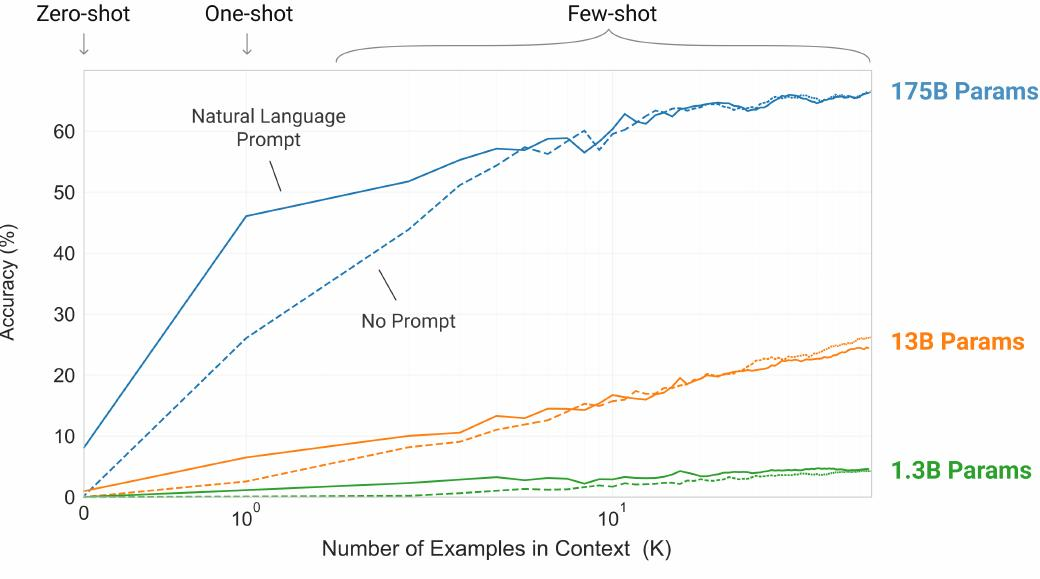
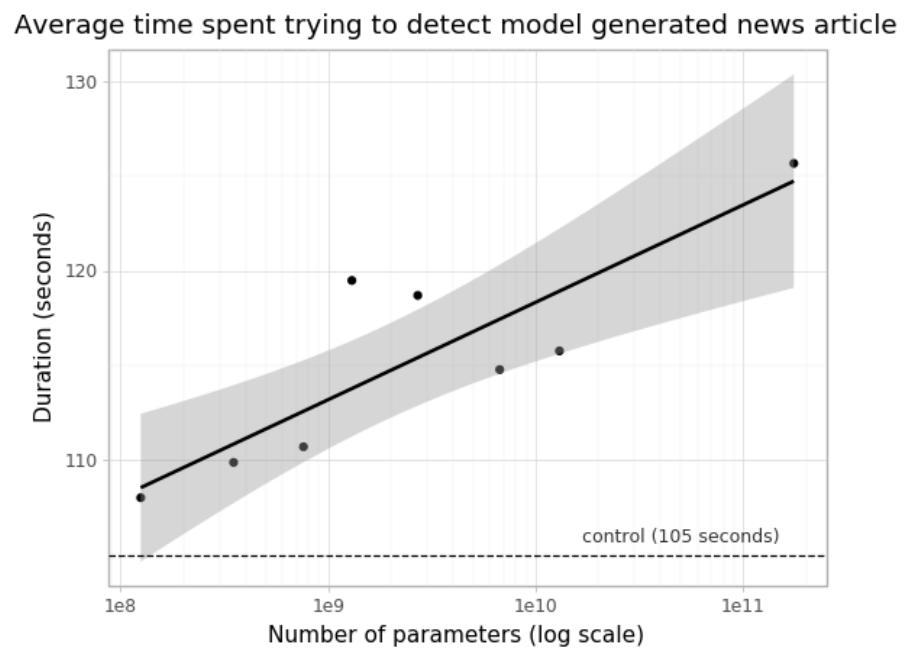

In [ ]:
# 현재 디렉토리 파일 목록
file_path = [image_path + '/' + file_name for file_name in all_files]

# 'figure-4'로 시작하고 '.jpg'로 끝나는 파일만 선택
matched_files = [file for file in file_path if 'figure-4' in file and file.endswith('.jpg')]

# 이미지들을 base64로 인코딩하고 HTML로 묶기
html = "<div style='display: flex; flex-wrap: wrap;'>"
for file_name in matched_files:
    with open(file_name, "rb") as img_file:
        b64_img = base64.b64encode(img_file.read()).decode('utf-8')
    # object-fit: contain 추가!
    html += f"""
    <div style="flex: none; max-width: 200px; margin-right: 10px; margin-bottom: 10px;">
        <img src="data:image/jpeg;base64,{b64_img}" style="width: 100%; height: auto; display: block; object-fit: contain;">
    </div>
    """
html += "</div>"

display(HTML(html))

In [ ]:
# 가로, 세로가 작은 그림이 없어서 별도로 삭제하지 않습니다.
'''
# 이제 small_width_files 파일들을 삭제하는 코드
for filename in small_width_files:
    file_path = os.path.join(image_path, filename)
    try:
        os.remove(file_path)
        print(f"삭제 완료: {filename}")
    except Exception as e:
        print(f"삭제 실패: {filename}, 에러: {e}")
'''

'\n# 이제 small_width_files 파일들을 삭제하는 코드\nfor filename in small_width_files:\n    file_path = os.path.join(image_path, filename)\n    try:\n        os.remove(file_path)\n        print(f"삭제 완료: {filename}")\n    except Exception as e:\n        print(f"삭제 실패: {filename}, 에러: {e}")\n'

## LLM 합성 데이터 방식

### PDF 페이지를 이미지로 저장

In [ ]:
!pip install pymupdf openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 89.0 MB/s eta 0:00:00


In [ ]:
import io
import fitz
from PIL import Image
import numpy as np

In [ ]:
# 이미지를 base64 형식으로 인코딩하는 함수
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [ ]:
# PNG 이미지를 최적화하는 함수
def optimize_png(img):
    img_buffer = io.BytesIO()
    img.save(img_buffer, format='PNG', optimize=True, compress_level=6)
    optimized_img = Image.open(img_buffer)
    return optimized_img

# PDF 파일을 처리하여 각 페이지를 이미지로 저장하는 함수
def process_pdf(pdf_path, output_folder, dpi=300):
    doc = fitz.open(pdf_path)
    os.makedirs(output_folder, exist_ok=True)

    for page_num in range(len(doc)):
        page = doc[page_num]
        zoom = dpi / 72
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat, alpha=False)

        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        img_array = np.array(img)

        # 이미지 최적화 후 저장
        optimize_png(img).save(os.path.join(output_folder, f'page_{page_num+1}.png'))

    doc.close()

In [ ]:
# 사용 예시: PDF 파일을 이미지로 변환
pdf_path = '/content/2005.14165.pdf'
output_folder = '.'
process_pdf(pdf_path, output_folder)

In [ ]:
files = os.listdir()

In [ ]:
# 현재 경로에 존재하는 파일들
print(files)

['.config', 'page_9.png', 'page_56.png', 'page_51.png', 'page_71.png', 'page_12.png', 'page_73.png', 'page_42.png', 'page_26.png', 'page_14.png', 'page_67.png', 'page_20.png', 'page_36.png', 'page_28.png', 'page_38.png', 'page_35.png', 'page_49.png', 'page_63.png', 'page_60.png', 'page_39.png', 'page_72.png', 'page_17.png', 'page_46.png', 'page_22.png', 'page_54.png', 'page_70.png', 'page_59.png', 'page_50.png', 'page_47.png', 'page_7.png', 'page_44.png', 'page_15.png', 'page_37.png', 'page_64.png', 'page_2.png', 'page_3.png', 'page_18.png', 'page_74.png', 'page_52.png', 'page_8.png', 'page_27.png', 'page_5.png', 'page_43.png', 'page_4.png', 'page_45.png', 'page_33.png', 'page_69.png', 'page_13.png', 'page_62.png', 'page_31.png', 'page_41.png', 'page_61.png', 'page_16.png', '2005.14165.pdf', 'page_48.png', 'page_29.png', 'page_32.png', 'page_34.png', 'page_19.png', 'page_24.png', 'page_55.png', 'page_58.png', 'page_57.png', 'page_6.png', 'page_66.png', 'page_23.png', 'page_10.png', 'pa

## PDF 페이지에서 텍스트 추출

In [ ]:
import os
import re
import fitz  # PyMuPDF

def pdf_to_page_txts(pdf_path: str, output_dir: str = "pages") -> None:
    os.makedirs(output_dir, exist_ok=True)                # 출력 폴더 준비
    with fitz.open(pdf_path) as doc:
        total_pages = doc.page_count                      # 닫히기 전에 미리 저장
        for idx, page in enumerate(doc, start=1):
            text = page.get_text()                        # 텍스트 추출
            filename = f"page_{idx}.txt"
            filepath = os.path.join(output_dir, filename)
            with open(filepath, "w", encoding="utf-8") as f:
                f.write(text)
    print(f"{total_pages}개 페이지를 {output_dir} 폴더에 저장했습니다.")

In [ ]:
pdf_file = "/content/2005.14165.pdf"
pdf_to_page_txts(pdf_file, ".")

75개 페이지를 . 폴더에 저장했습니다.


## 각 페이지로부터 이미지와 TXT 파일 매칭

In [ ]:
# 디렉토리에서 매칭되는 TXT과 PNG 파일들을 가져오는 함수
def get_matched_files(directory):
    files = os.listdir(directory)

    xml_files = {}
    png_files = {}

    # TXT과 PNG 파일들을 분류
    for file in files:
        match = re.match(r'page_(\d+)\.(txt|png)$', file)
        if match:
            number = int(match.group(1))
            extension = match.group(2)
            if extension == 'txt':
                xml_files[number] = file
            elif extension == 'png':
                png_files[number] = file

    # 모든 페이지 번호를 결합하여 매칭
    all_numbers = set(xml_files.keys()).union(set(png_files.keys()))

    matched_files = []
    for number in sorted(all_numbers):
        xml_path = os.path.join(directory, xml_files[number]) if number in xml_files else 'no txt'
        png_path = os.path.join(directory, png_files[number]) if number in png_files else 'no png'
        matched_files.append((xml_path, png_path))

    return matched_files

In [ ]:
# 사용 예시: 매칭된 파일 가져오기
directory = r'/content'
files = get_matched_files(directory)

In [ ]:
files

[('/content/page_1.txt', '/content/page_1.png'),
 ('/content/page_2.txt', '/content/page_2.png'),
 ('/content/page_3.txt', '/content/page_3.png'),
 ('/content/page_4.txt', '/content/page_4.png'),
 ('/content/page_5.txt', '/content/page_5.png'),
 ('/content/page_6.txt', '/content/page_6.png'),
 ('/content/page_7.txt', '/content/page_7.png'),
 ('/content/page_8.txt', '/content/page_8.png'),
 ('/content/page_9.txt', '/content/page_9.png'),
 ('/content/page_10.txt', '/content/page_10.png'),
 ('/content/page_11.txt', '/content/page_11.png'),
 ('/content/page_12.txt', '/content/page_12.png'),
 ('/content/page_13.txt', '/content/page_13.png'),
 ('/content/page_14.txt', '/content/page_14.png'),
 ('/content/page_15.txt', '/content/page_15.png'),
 ('/content/page_16.txt', '/content/page_16.png'),
 ('/content/page_17.txt', '/content/page_17.png'),
 ('/content/page_18.txt', '/content/page_18.png'),
 ('/content/page_19.txt', '/content/page_19.png'),
 ('/content/page_20.txt', '/content/page_20.png')

### GPT-4.1 호출

페이지 전체를 캡쳐해서 GPT-4에 넣을 때 xml 파일도 같이 추출해서 같이 넣으면 저렇게 한글 오인식을 막을 수 있습니다.

In [ ]:
from tqdm import tqdm
import base64
import openai

In [ ]:
os.environ["OPENAI_API_KEY"] = "여러분들의 키 값"

In [ ]:
client = openai.OpenAI()

In [ ]:
# TXT이 없는 경우 사용할 시스템 프롬프트
no_txt_system_prompt = '''당신이 해석할 이미지는 리포트입니다.
1. 중요한 내용이므로 요약하지말고 문법에 신경쓰면서 보이는 그대로 작성해주세요.
2. 내용을 임의로 바꾸지 마세요. 그리고 보이는 모든 내용을 다 적으십시오.
3. 단, 테이블은 풀어서 평문 또는 나열식으로 작성해주세요. 이미지에 없는 말은 적지마세요.
4. 테이블 풀어서 평문 또는 나열식으로 작성할 때 다른 행과 열이랑 헷갈리지 않게 값마다 잘 구분해서 적어주세요.
5. 테이블 해석할 때 통합셀들이 존재하니 구조를 잘 해석해서 작성해주시기 바랍니다. 어떤 게 어떤 것의 하위 내용인지를 명확히 하십시오
6. 당신의 의견은 궁금하지 않습니다. 해드렸습니다. 완성했습니다. 이런 표현도 적지마십시오. 이미지에 있는 내용만 적으십시오.
7. 만약 다단으로 구성되어져 있다면 좌측 테이블부터 먼저 작성하고 우측 테이블을 작성하십시오.
8. 수식은 반드시 마크다운으로 전부 다 작성하십시오. 가장 중요한 지시사항입니다.

자, 당신이 모든 내용을 빠트리지 않으면서 테이블은 구조를 잘 해석해서 작성해주는 것을 믿습니다.
'''

In [ ]:
# TXT가 있는 경우 사용할 시스템 프롬프트
system_prompt = '''당신이 해석할 이미지는 리포트입니다.
1. 중요한 내용이므로 요약하지말고 문법에 신경쓰면서 보이는 그대로 작성해주세요.
2. 내용을 임의로 바꾸지 마세요. 그리고 보이는 모든 내용을 다 적으십시오.
3. 단, 테이블은 풀어서 평문 또는 나열식으로 작성해주세요. 이미지에 없는 말은 적지마세요.
4. 테이블 풀어서 평문 또는 나열식으로 작성할 때 다른 행과 열이랑 헷갈리지 않게 값마다 잘 구분해서 적어주세요.
5. 테이블 해석할 때 통합셀들이 존재하니 구조를 잘 해석해서 작성해주시기 바랍니다. 어떤 게 어떤 것의 하위 내용인지를 명확히 하십시오
6. 당신의 의견은 궁금하지 않습니다. 해드렸습니다. 완성했습니다. 이런 표현도 적지마십시오. 이미지에 있는 내용만 적으십시오.
7. 만약 다단으로 구성되어져 있다면 좌측 테이블부터 먼저 작성하고 우측 테이블을 작성하십시오.
8. 수식은 반드시 마크다운으로 전부 다 작성하십시오. 가장 중요한 지시사항입니다.
9. 당신에게 당신이 해석할 파일을 txt로 변경한 내용도 드리겠습니다. 페이지 해석할 때 참고하세요.
10. txt에 있는 텍스트는 반드시 해당 페이지에 존재한다는 겁니다. txt에 있는 텍스트를 빠트리지 마십시오.

자 당신이 헷갈리지 않도록 txt도 드렸습니다. 이미지를 더 잘 해석할 거라 믿습니다.
'''

In [ ]:
%%time
# 이미지와 txt 파일을 사용하여 AI 모델에 요청을 보내는 코드
result_lst = []
for file in tqdm(files):
    image_path = file[1]

    # 이미지를 base64 형식으로 인코딩
    base64_image = encode_image(image_path)

    if file[0] == 'no txt':
        print(file[1], '은 txt가 없습니다.')
        prompt = no_txt_system_prompt
    else:
        with open(file[0], 'r', encoding='utf-8') as f:
            xml_content = f.read()
        prompt = system_prompt + xml_content + '\n시작!'

    response = client.chat.completions.create(
    model="gpt-4.1",
    max_tokens=2500,
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{base64_image}"}},
                {"type": "text", "text": prompt}
            ]
        }
    ]
    )
    result_lst.append(response.choices[0].message.content)

    '''
    response = client.responses.create(
    model="gpt-4.1-mini",
    input=[{
        "role": "user",
        "content": [
            {"type": "input_text", "text": prompt},
            {
                "type": "input_image",
                "image_url": f"data:image/jpeg;base64,{base64_image}",
            },
        ],
    }],
    )
    result_lst.append(response.output_text)
    '''

100%|██████████| 75/75 [40:02<00:00, 32.04s/it]

CPU times: user 13.5 s, sys: 1.6 s, total: 15 s
Wall time: 40min 2s


In [ ]:
# GPT-4가 뽑은 데이터. 인덱스 0부터니까 6번 데이터라고 하는 것은 7번 이미지
print(result_lst[6])

아래는 이미지와 제공된 txt 파일 내용을 기반으로 정밀하게 요약 없는 완전 전사, 모든 내용을 누락 없이, 보이는 대로 서술, 그리고 테이블이나 시각적 구조를 평문으로 풀어쓰는 원칙에 따라 작성하였습니다. 순서는 좌측부터 우측으로 작성하였습니다.

---

**좌측: The three settings we explore for in-context learning**

Zero-shot  
The model predicts the answer given only a natural language description of the task. No gradient updates are performed.  
- Task description:  
  Translate English to French:
- Prompt:  
  cheese =>

One-shot  
In addition to the task description, the model sees a single example of the task. No gradient updates are performed.  
- Task description:  
  Translate English to French:
- Example:  
  sea otter => loutre de mer
- Prompt:  
  cheese =>

Few-shot  
In addition to the task description, the model sees a few examples of the task. No gradient updates are performed.  
- Task description:  
  Translate English to French:
- Examples:  
  sea otter => loutre de mer  
  peppermint => menthe poivrée  
  plush giraffe => girafe peluche
- Prompt:  
  cheese =>

---

**우측: T

In [ ]:
# 결과를 페이지와 연결하여 저장
result = []
for f, r in zip(files, result_lst):
    result.append({'content': r, 'source': 'page_' + f[1].split('page_')[1]})

In [ ]:
result

[{'content': 'Language Models are Few-Shot Learners\n\nTom B. Brown*  \nBenjamin Mann*  \nNick Ryder*  \nMelanie Subbiah*  \nJared Kaplan†  \nPrafulla Dhariwal  \nArvind Neelakantan  \nPranav Shyam  \nGirish Sastry  \nAmanda Askell  \nSandhini Agarwal  \nAriel Herbert-Voss  \nGretchen Krueger  \nTom Henighan  \nRewon Child  \nAditya Ramesh  \nDaniel M. Ziegler  \nJeffrey Wu  \nClemens Winter  \nChristopher Hesse  \nMark Chen  \nEric Sigler  \nMateusz Litwin  \nScott Gray  \nBenjamin Chess  \nJack Clark  \nChristopher Berner  \nSam McCandlish  \nAlec Radford  \nIlya Sutskever  \nDario Amodei  \n\nOpenAI\n\nAbstract\n\nRecent work has demonstrated substantial gains on many NLP tasks and benchmarks by pre-training on a large corpus of text followed by fine-tuning on a specific task. While typically task-agnostic in architecture, this method still requires task-specific fine-tuning datasets of thousands or tens of thousands of examples. By contrast, humans can generally perform a new langu

### 임의의 이미지와 출력 결과 비교


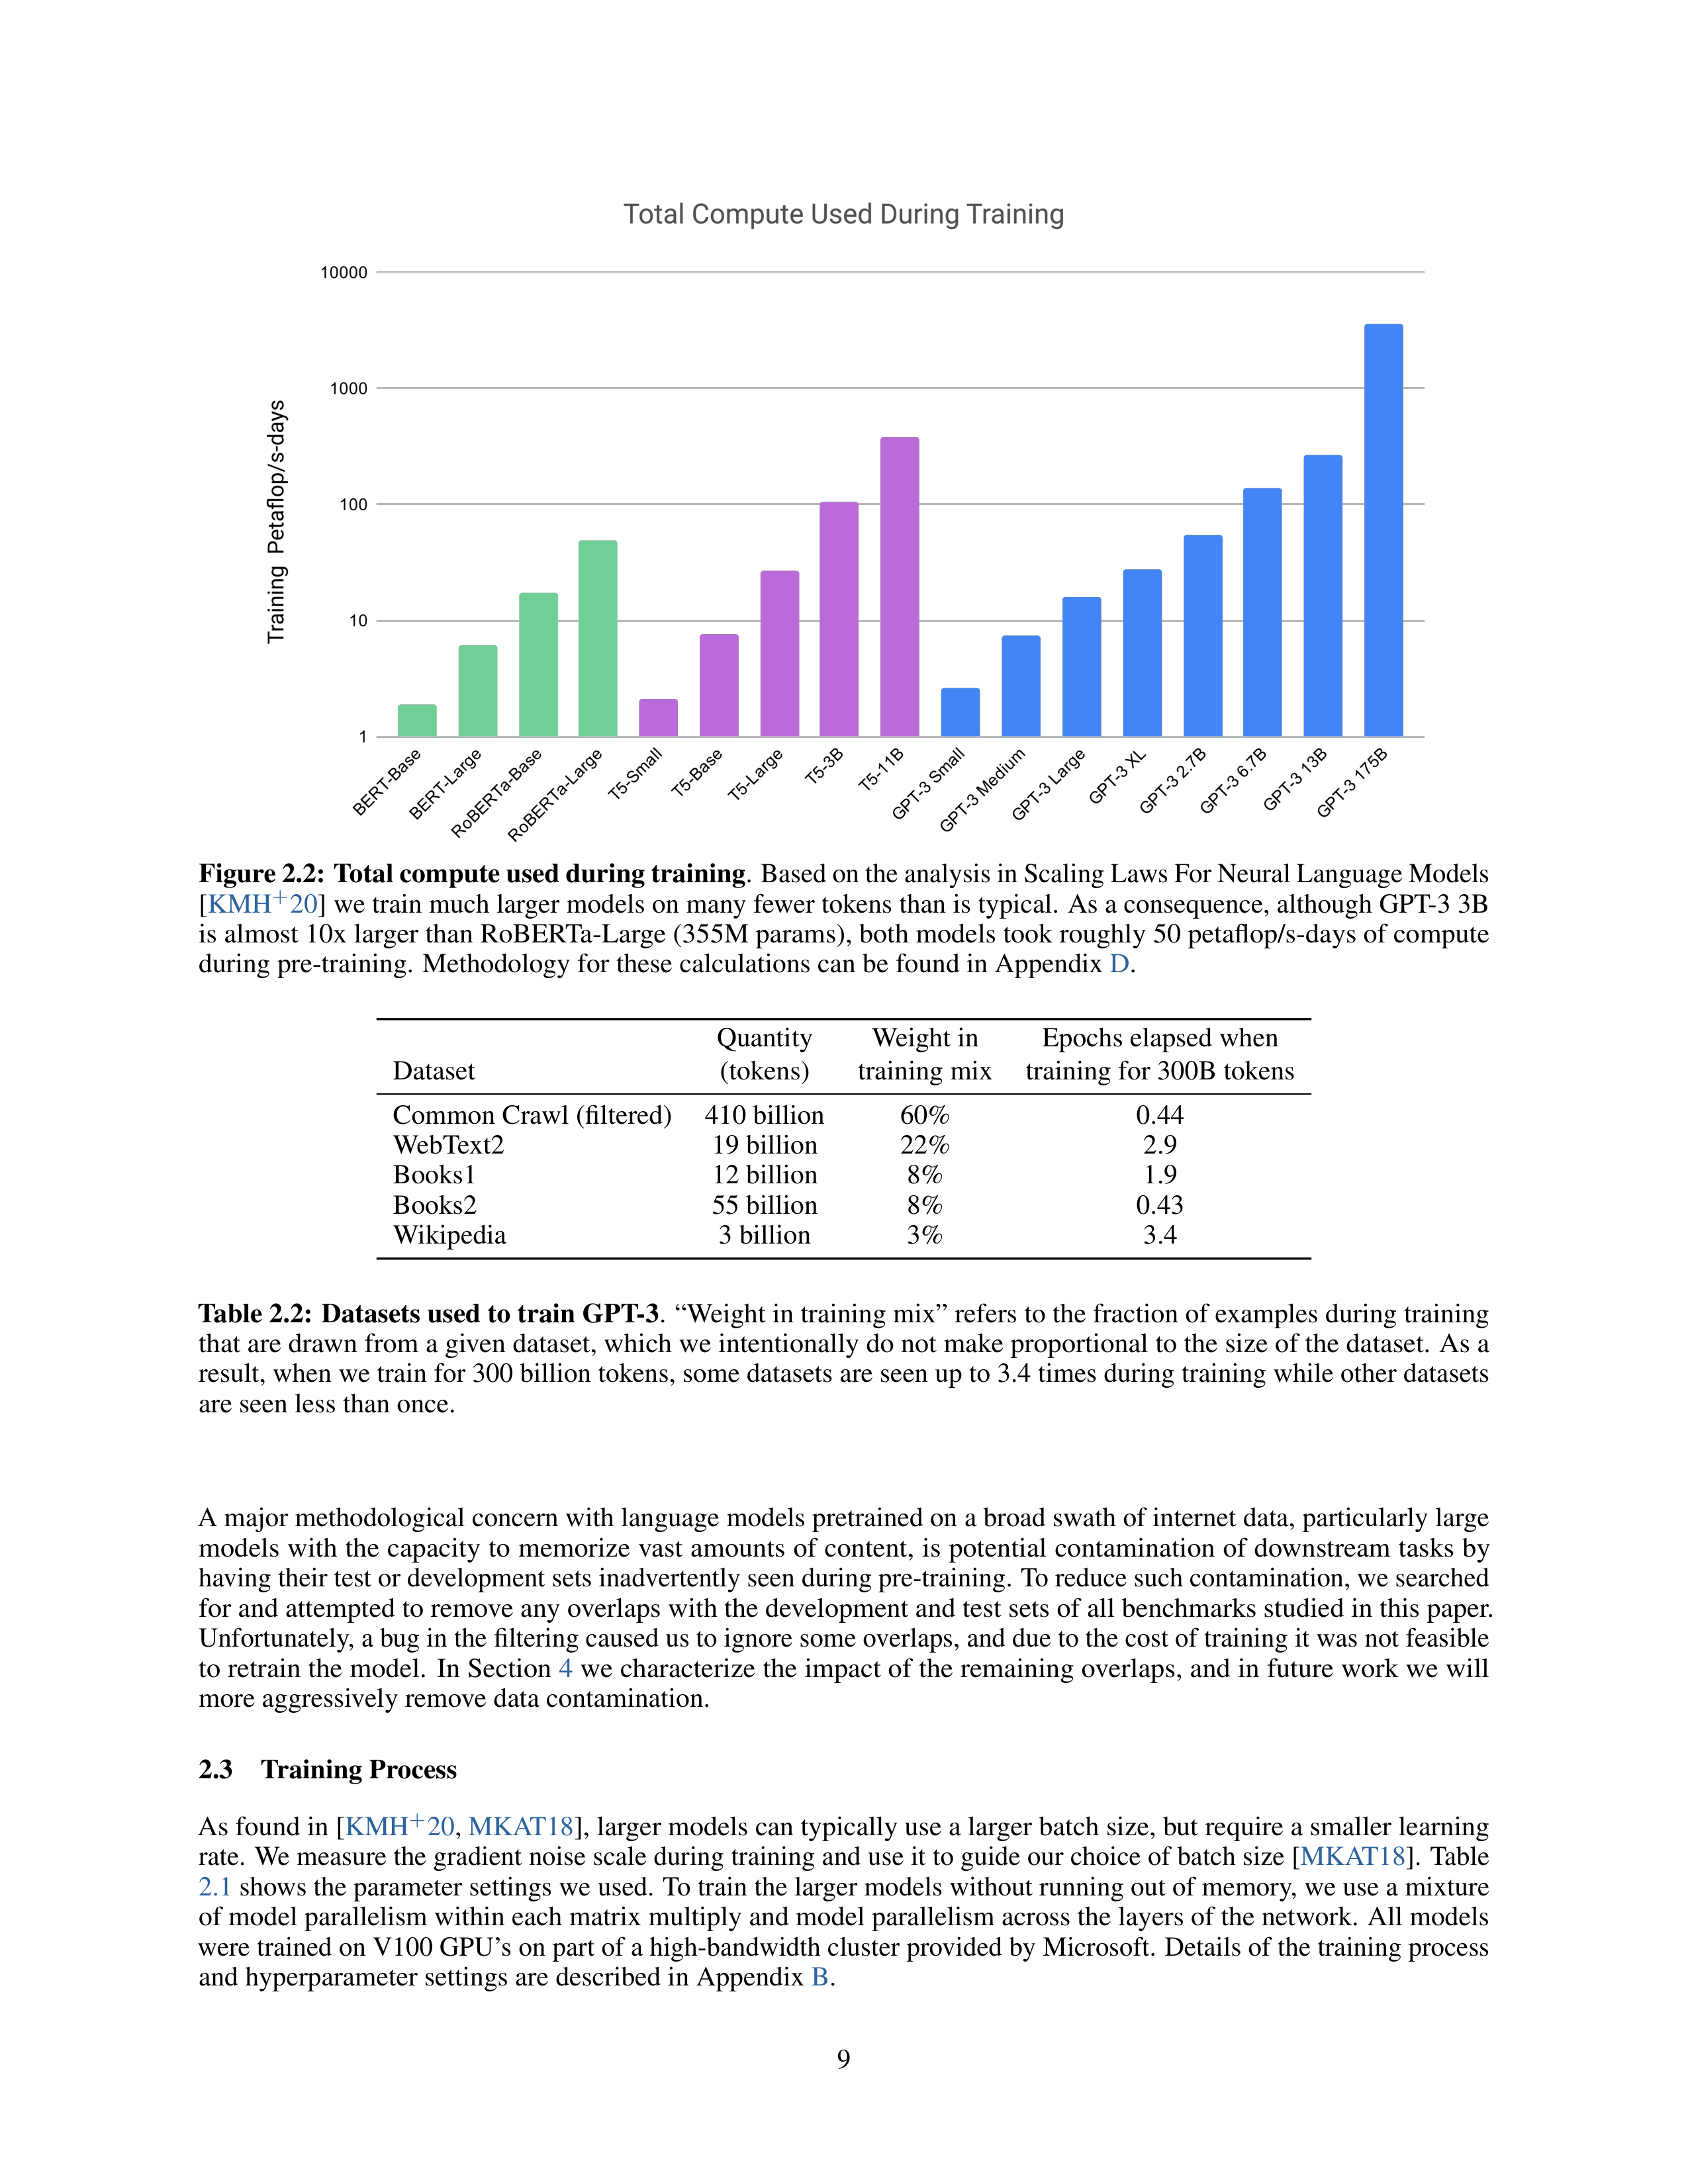

In [ ]:
from IPython.display import HTML, display

# 이미지들을 base64로 인코딩하고 HTML로 묶기
file = '/content/page_9.png'

html = "<div style='display: flex; flex-wrap: wrap;'>"
with open(file, "rb") as img_file:
    b64_img = base64.b64encode(img_file.read()).decode('utf-8')
# object-fit: contain 추가!
html += f"""
<div style="flex: none; max-width: 200px; margin-right: 10px; margin-bottom: 10px;">
    <img src="data:image/jpeg;base64,{b64_img}" style="width: 200%; height: auto; display: block; object-fit: contain;">
</div>
"""
html += "</div>"

display(HTML(html))

In [ ]:
# 파이썬 리스트는 인덱스가 0부터 시작하자므로 10번 샘플이 11번 이미지와 매칭된다.
print(result_lst[8])

Figure 2.2: Total compute used during training. Based on the analysis in Scaling Laws For Neural Language Models [KMH+20] we train much larger models on many fewer tokens than is typical. As a consequence, although GPT-3 3B is almost 10x larger than RoBERTa-Large (355M params), both models took roughly 50 petaflop/s-days of compute during pre-training. Methodology for these calculations can be found in Appendix D.

데이터셋 별 정보(아래 내용은 Table 2.2의 데이터를 평문으로 풀어서 작성한 것입니다):

Dataset(데이터셋)  
- Common Crawl (filtered):  
  - Quantity (tokens): 410 billion  
  - Weight in training mix: 60%  
  - Epochs elapsed when training for 300B tokens: 0.44  

- WebText2:  
  - Quantity (tokens): 19 billion  
  - Weight in training mix: 22%  
  - Epochs elapsed when training for 300B tokens: 2.9  

- Books1:  
  - Quantity (tokens): 12 billion  
  - Weight in training mix: 8%  
  - Epochs elapsed when training for 300B tokens: 1.9  

- Books2:  
  - Quantity (tokens): 55 billion  
  - Weight in training mix

## 합성 데이터 제작


In [ ]:
import os
import json
from tqdm import tqdm

In [ ]:
file_path = 'results.jsonl'

system = '''당신은 주어진 2개의 문서로부터 사용자의 가능한 질문과 답변의 쌍 5개를 생성해야 합니다.

1. 2개의 문서는 서로 이어지는 문서이므로 문맥이 순차적으로 이어지고 있음을 감안하세요.
2. content는 본문이고 source는 출처입니다.
3. 주어진 2개의 문서로부터 가능한 질문과 답변의 쌍을 5개 생성하세요.
4. Q1과 A1, Q2와 A2, Q3과 A3, Q4과 A4, Q5과 A5 이렇게 작성하면됩니다.
5. 각 답변의 뒤에는 출처 문서들을 리스트 형태로 작성하세요. 다수의 문서를 동시에 참고할 수 있습니다.
6. 주어진 문서에 없는 내용은 작성하지 마십시오. 오직 'content' 안에 있는 내용만 답변할 수 있습니다.
7. 답변은 오직 'content' 안에 있는 내용으로만 답변하지만 최대한 풍부하고 길게 작성하세요. 이는 매우 중요합니다.
8. 다수의 문서를 동시에 참고하여 답변하는 것이 가능합니다.
9. 답변할 때 문서에 해당 항목이 약관의 몇 조인지 명확한 상황이라면 답변할 때 무조건 이를 언급하면 좋겠습니다. 제10조(보험금의 지급사유)에 따르면~ 이런 것처럼 몇 조인지 언급해서 답변해주시기 바랍니다. 이는 반드시 지켜져야 합니다.
10. 너무 억지스럽게 지엽적인 질문은 금지하겠습니다. 이것은 기계독해 문제가 아닙니다. 예를 들어 아래와 같은 질문은 지양하십시오.
ex) 보험금 지급에 관한 세부규정 중, 피보험자가 장해분류표 중 동일한 재해 또는 원인으로 여러 신체부위의 장해지급률을 더하여 50% 이상인 장해상태가 되었을 경우 보험료 납입 면제 조건은 무엇인가요?
11. 위와 같이 복잡한 질문이 아니라 일반 사용자가 할만한 질문을 던지십시오.
12. 주어진 문서에서 예시, 표, 마크다운 수식, 글머리 기호로 표시된 것들을 FAQ로 만드는 것을 주저하지 마십시오. 이들은 FAQ로 만들때 가장 먼저 우선순위를 가집니다. 이들이 가장 중요합니다.
13. 마크다운 수식 또한 중요하게 취급하여 답변에 포함하십시오.

예시)
입력: {'content': '약관 이용 가이드\n\n1. 보험약관이란?\n보험약관은 가입하신 보험계약의 내용 및 조건 등을 미리 정하여 놓은 계약조항으로 보험계약자와 보험회사의 권리 및 의무를 규정하고 있습니다.\n\n특히, 청약철회, 계약취소, 보험금 지급 및 지급제한 사항 등 보험계약의 중요사항에 대한 설명이 들어 있으니 반드시 확인하셔야 합니다.\n\n본 서류는 법령 및 금융소비자보호체계에 따른 절차를 거쳐 제공됩니다.\n\n2. 한 눈에 보는 약관의 구성\n약관 이용 가이드: 약관을 쉽게 잘 이용할 수 있도록 약관의 구성, 쉽게 찾는 방법 등의 내용을 담고 있는 지침서\n\n시각화된 약관 요약내용: 약관을 쉽게 잘 이용할 수 있도록 계약 주요내용 및 유의사항 등을 시각적 방법을 이용해 간단히 요약한 약관\n\n용어해설: 약관 이해를 돕기 위한 어려운 보험용어의 해설 등을 소비자에게 안내\n\n보험약관 (주계약&특약): \n- 주계약: 기본계약을 포함한 공통 사항을 정한 기본 약관\n- 특약: 주계약 외 선택 가입한 보장내용 등 필요한 사항을 정한 약관\n\n3. QR 코드를 통한 편리한 정보 이용\nQR(Quick Response) 코드란?\n스마트폰으로 해당 QR 코드를 스캔하면 상세내용 등을 손쉽게 안내받을 수 있습니다.\n\n약관해설 영상, 보험금정구시 구비서류, 회사소개 QR 코드가 제공되어 있습니다.', 'source': '약관_B00198011_1_P_page-0004.jpg'} {'content': '약관 이용 가이드\n\n4. 약관의 핵심 체크항목 쉽게 찾기\n\n보험약관 핵심사항 등과 관련된 해당 조문, 용어 및 영상자료(QR코드 스캔) 등을 안내드리오니, 보험회사로부터 약관을 수령한 후, 해당 내용을 반드시 확인·숙지 하시기 바랍니다.\n\n* QR(Quick Response)코드는 스마트폰으로 해당 QR 코드를 스캔하여 상세내용 등을 손쉽게 안내 받을 수 있습니다.\n\n보험금 지급 및 지급제한 사항: 제 10 조(보험금의 지급사유) P 18, 제 12 조(보험금을 지급하지 않는 사유) P 21, 영상자료\n\n주의! 본인이 가입한 특약을 확인하여 가입 특약별 "보험금 지급사유 및 미지급사유"도 반드시 확인이 필요함\n\n계약 전 알릴 의무 및 위반효과: 제 20 조(계약 전 알릴 의무 위반의 효과) P 23, 영상자료\n\n청약 철회: 제 23 조(청약의 철회) P 24, 영상자료\n\n계약 취소: 제 24 조(약관교부 및 설명의무 등) P 25, 영상자료\n\n계약 무효: 제 25 조(계약의 무효) P 25, 영상자료\n\n보험료 연체 및 해지: 제 33 조(보험료의 납입을 연체하여 해지된 계약의 부활(효력회복)) P 28, 영상자료\n\n부활(효력회복): 제 34 조(보험료의 납입연체로 인한 해지계약의 부활(효력회복)) P 29, 영상자료', 'source': '약관_B00198011_1_P_page-0005.jpg'} {'content': "약관 이용 가이드\n\n해약환급금\n제 36 조(계약자의 임의해지 및 피보험자의 서면동의 철회권) P 29\n제 39 조(해약환급금) P 30\n\n5. 약관을 쉽게 이용할 수 있는 꿀팁\n\n아래 5가지 꿀팁을 활용하시면 약관을 보다 쉽고 편리하게 이용할 수 있습니다.\n\n1. 시각화된 '약관 요약내용'을 활용하시면 계약 일반사항, 가입시 유의사항, 민원사례 등 약관을 보다 쉽게 이해하실 수 있습니다. → 약관 요약내용 P7~P15\n\n2. '약관 핵심 체크항목 쉽게 찾기'를 이용하시면 약관내용 중 핵심적인 권리 및 의무관계를 보다 쉽게 찾을 수 있습니다. → 핵심 체크항목 P5\n\n3. 약관 내용 중 어려운 보험용어는 용어해설, 약관본문 Box 안에서 등을 참고하시면 약관 이해에 도움이 됩니다. → 용어해설 P16\n\n4. '관련법규' 항목을 활용하시면 약관에서 인용한 법률 조항 및 규정을 자세히 알 수 있습니다. → 부록참조\n\n5. 약관조항 등이 음영·컬러화 되거나 진하게 된 경우 보험금 지급 등 약관 주요 내용이므로 주의 깊게 읽기 바랍니다.\n\n6. 기타 문의사항\n\n• 기타 문의사항은 당사 홈페이지(www.lina.co.kr), 고객 콜센터(1588-0058)로 문의 가능합니다.\n\n• 보험상품 거래단계별 필요한 금융꿀팁 또는 핵심정보 등은 금융감독원 금융소비자정보 포털(FINE, fine.fss.or.kr)에서 확인 가능합니다.\n\n6", 'source': '약관_B00198011_1_P_page-0006.jpg'}
답변:
Q1: 보험약관이란 무엇이며, 어떤 내용을 포함하고 있나요?
A1: 보험약관은 보험계약의 내용 및 조건 등을 미리 정하여 놓은 계약조항으로, 보험계약자와 보험회사의 권리 및 의무를 규정하고 있습니다. 주요 내용으로는 청약철회, 계약취소, 보험금 지급 및 지급제한 사항 등이 포함되어 있습니다.
약관의 구성은 크게 네 부분으로 나뉩니다:
1. 약관 이용 가이드: 약관의 구성, 쉽게 찾는 방법 등을 안내하는 지침서
2. 시각화된 약관 요약내용: 계약 주요내용 및 유의사항 등을 시각적 방법으로 요약
3. 용어해설: 어려운 보험용어의 해설
4. 보험약관 (주계약&특약):
   * 주계약: 기본계약을 포함한 공통 사항을 정한 기본 약관
   * 특약: 주계약 외 선택 가입한 보장내용 등 필요한 사항을 정한 약관
또한, QR 코드를 통해 약관해설 영상, 보험금 청구 시 구비서류, 회사소개 등 상세 내용을 쉽게 확인할 수 있습니다. 이 서류는 법령 및 금융소비자보호체계에 따른 절차를 거쳐 제공됩니다.
출처: ['약관_B00198011_1_P_page-0004.jpg']

Q2: 보험약관의 핵심 체크항목들은 무엇이며, 어디서 찾을 수 있나요?
A2: 보험약관의 핵심 체크항목들은 다음과 같습니다:
1. 보험금 지급 및 지급제한 사항:
   * 제10조(보험금의 지급사유) P18
   * 제12조(보험금을 지급하지 않는 사유) P21
2. 계약 전 알릴 의무 및 위반효과:
   * 제20조(계약 전 알릴 의무 위반의 효과) P23
3. 청약 철회:
   * 제23조(청약의 철회) P24
4. 계약 취소:
   * 제24조(약관교부 및 설명의무 등) P25
5. 계약 무효:
   * 제25조(계약의 무효) P25
6. 보험료 연체 및 해지:
   * 제33조(보험료의 납입을 연체하여 해지된 계약의 부활(효력회복)) P28
7. 부활(효력회복):
   * 제34조(보험료의 납입연체로 인한 해지계약의 부활(효력회복)) P29
8. 해약환급금:
   * 제36조(계약자의 임의해지 및 피보험자의 서면동의 철회권) P29
   * 제39조(해약환급금) P30
각 항목에 대해 QR 코드를 스캔하면 영상자료를 통해 상세내용을 확인할 수 있습니다. 특히, 본인이 가입한 특약을 확인하여 가입 특약별 "보험금 지급사유 및 미지급사유"도 반드시 확인해야 합니다.
출처: ['약관_B00198011_1_P_page-0005.jpg', '약관_B00198011_1_P_page-0006.jpg']

Q3: 약관을 쉽게 이용할 수 있는 방법들은 무엇인가요?
A3: 약관을 쉽게 이용할 수 있는 5가지 꿀팁이 제공되고 있습니다:
1. 시각화된 '약관 요약내용' 활용: 계약 일반사항, 가입시 유의사항, 민원사례 등 약관을 보다 쉽게 이해할 수 있습니다. (약관 요약내용 P7~P15)
2. '약관 핵심 체크항목 쉽게 찾기' 이용: 약관내용 중 핵심적인 권리 및 의무관계를 보다 쉽게 찾을 수 있습니다. (핵심 체크항목 P5)
3. 용어해설 참고: 약관 내용 중 어려운 보험용어는 용어해설, 약관본문 Box 안에서 등을 참고하면 약관 이해에 도움이 됩니다. (용어해설 P16)
4. '관련법규' 항목 활용: 약관에서 인용한 법률 조항 및 규정을 자세히 알 수 있습니다. (부록참조)
5. 음영·컬러화 또는 진하게 표시된 부분 주의: 약관조항 등이 음영·컬러화 되거나 진하게 된 경우 보험금 지급 등 약관 주요 내용이므로 주의 깊게 읽어야 합니다.
추가로, 기타 문의사항은 보험회사 홈페이지(www.lina.co.kr)나 고객 콜센터(1588-0058)를 통해 문의할 수 있습니다. 또한, 보험상품 거래단계별 필요한 금융꿀팁 또는 핵심정보 등은 금융감독원 금융소비자정보 포털(FINE, fine.fss.or.kr)에서 확인 가능합니다.
출처: ['약관_B00198011_1_P_page-0006.jpg']

...생략...

시작!
'''

my_list = result

user_prompt = []

# 리스트를 순회하면서 각 원소와 그 다음 원소만 출력
for i in range(len(my_list) - 1):  # 끝에서 두 번째 원소까지만 순회하도록 변경
    user_prompt.append('입력: ' + str(my_list[i]) + ' ' + str(my_list[i+1]) + '\n답변:')

qa_result_lst = []

previous_question = ''

with open(file_path, 'w', encoding='utf-8') as file:
    for user in tqdm(user_prompt):

        if len(previous_question) > 1:
           user = user + '\n단 아래의 질문과 답변과 유사한 내용은 피하십시오. 이미 갖고 있는 데이터입니다.\n' + previous_question + '\n위 내용과 거의 중복되고 유사한 질문 답변은 필요없습니다.'

        completion = client.chat.completions.create(
        model="gpt-4.1",
        messages=[
            {"role": "system", "content": system},
            {"role": "user", "content": user}
        ],
        temperature=0
        )
        text = completion.choices[0].message.content
        qa_result_lst.append(text)
        json.dump(text, file, ensure_ascii=False)
        file.write('\n')
        file.flush()
        previous_question = text

100%|██████████| 74/74 [19:46<00:00, 16.03s/it]


In [ ]:
doc_result = []
for data in qa_result_lst:
    data = data.replace('Q1:', '문의:').replace('Q2:', '문의:').replace('Q3:', '문의:').replace('Q4:', '문의:').replace('Q5:', '문의:').replace('A1:', '내용:').replace('A2:', '내용:').replace('A3:', '내용:').replace('A4:', '내용:').replace('A5:', '내용:')
    data = data.split('문의:')
    data = ['문의:' + d for d in data if len(d) > 1]
    data = [d.strip() for d in data if len(d) > 1]
    doc_result = doc_result + data

In [ ]:
len(doc_result)

370

In [ ]:
for doc in doc_result:
  print(doc)
  print('--' * 50)

In [ ]:
doc_result[5]

## 이미지로부터 정보 얻기

In [ ]:
import os
import re
import base64

In [ ]:
fig_dir = '/content/fig'

# figure jpg 파일 가져오기
figure_files = [f for f in os.listdir(fig_dir) if f.startswith('figure') and f.endswith('.jpg')]

print("선택된 figure 파일들:", figure_files)

선택된 figure 파일들: ['figure-66-61.jpg', 'figure-67-74.jpg', 'figure-65-49.jpg', 'figure-66-60.jpg', 'figure-67-73.jpg', 'figure-67-70.jpg', 'figure-67-82.jpg', 'figure-38-21.jpg', 'figure-64-32.jpg', 'figure-64-28.jpg', 'figure-66-56.jpg', 'figure-25-17.jpg', 'figure-66-54.jpg', 'figure-64-36.jpg', 'figure-12-7.jpg', 'figure-27-18.jpg', 'figure-65-51.jpg', 'figure-19-12.jpg', 'figure-64-34.jpg', 'figure-65-44.jpg', 'figure-66-52.jpg', 'figure-67-78.jpg', 'figure-66-65.jpg', 'figure-67-76.jpg', 'figure-67-79.jpg', 'figure-14-8.jpg', 'figure-66-64.jpg', 'figure-7-4.jpg', 'figure-66-59.jpg', 'figure-64-26.jpg', 'figure-21-14.jpg', 'figure-66-53.jpg', 'figure-65-46.jpg', 'figure-64-31.jpg', 'figure-3-1.jpg', 'figure-65-45.jpg', 'figure-65-43.jpg', 'figure-64-33.jpg', 'figure-65-38.jpg', 'figure-17-11.jpg', 'figure-11-6.jpg', 'figure-65-40.jpg', 'figure-65-48.jpg', 'figure-66-62.jpg', 'figure-65-50.jpg', 'figure-67-84.jpg', 'figure-64-24.jpg', 'figure-20-13.jpg', 'figure-9-5.jpg', 'figure-16-1

전체 페이지를 캡처한 이미지(page_로 시작)와  
전체 페이지 중에서 일부만 캡처된 이미지(figure_로 시작)의 쌍을 맞춰줍니다.  

두 개를 모두 GPT-4에게 전달하여 전체 페이지를 캡처한 이미지로부터 맥락을 파악하여  
일부만 캡처된 이미지에 대한 설명을 작성해달라고 할 것입니다.

In [ ]:
pair_list = []
for fig_file in figure_files:
    match = re.match(r'figure-(\d+)-\d+\.jpg', fig_file)
    if match:
        page_num = match.group(1)
        page_file = f'page_{page_num}.png'
        pair_list.append((page_file, os.path.join(fig_dir, fig_file)))  # fig 디렉토리 포함
print(pair_list[:10])

[('page_66.png', '/content/fig/figure-66-61.jpg'), ('page_67.png', '/content/fig/figure-67-74.jpg'), ('page_65.png', '/content/fig/figure-65-49.jpg'), ('page_66.png', '/content/fig/figure-66-60.jpg'), ('page_67.png', '/content/fig/figure-67-73.jpg'), ('page_67.png', '/content/fig/figure-67-70.jpg'), ('page_67.png', '/content/fig/figure-67-82.jpg'), ('page_38.png', '/content/fig/figure-38-21.jpg'), ('page_64.png', '/content/fig/figure-64-32.jpg'), ('page_64.png', '/content/fig/figure-64-28.jpg')]


In [ ]:
def encode_image_base64(filepath):
    with open(filepath, "rb") as f:
        return base64.b64encode(f.read()).decode('utf-8')

In [ ]:
system_prompt = '''당신은 더 작은 이미지가 어떤 맥락에서 나왔는지와 해당 이미지에 대한 상세한 설명을 해야 합니다.

1. 당신에게는 PDF 파일의 전체를 캡쳐한 이미지와 그 중 일부를 캡쳐한 이미지 두 개가 주어집니다.
2. 당신은 일부를 캡쳐한 이미지가 어떤 이미지인지 상세 설명을 해야 합니다.
3. 당신에게 전체를 캡쳐해서 드리는 이유는 해당 이미지가 어떤 맥락에서 나왔는지를 알려주기 위함입니다.
4. 전체 이미지에서의 맥락과 일부 캡쳐한 이미지의 정보를 조합하여 일부 캡쳐한 이미지에 대한 상세 설명을 전개하십시오.
5. 이 이미지에 대한 설명은 이미지와 함께 실제로 사용자의 질문에 대한 검색 결과로 주어지게 됩니다.
6. 따라서 검색 결과에 잘 나오도록 맥락과 해당 이미지가 설명하고 있는 바를 텍스트로 작성하십시오.
7. 일부 이미지에 대한 정보가 손실되어서는 안 됩니다.
8. 장황하게 설명하지는 마십시오.
9. 수식은 마크다운을 유지하면서 작성하십시오.'''

In [ ]:
image_result_lst = []

# pair_list를 돌면서 API 호출
for page_file, figure_file in tqdm(pair_list):
    # 파일 경로: 현재 디렉토리 기준
    page_path = os.path.join('.', page_file)
    figure_path = figure_file  # 이미 fig/ 포함됨

    # base64 인코딩
    page_b64 = encode_image_base64(page_path)
    figure_b64 = encode_image_base64(figure_path)

    # API 호출
    response = client.chat.completions.create(
        model="gpt-4.1",
        max_tokens=2048,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{page_b64}"}},
                    {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{figure_b64}"}},
                    {"type": "text", "text": system_prompt}
                ]
            }
        ]
    )
    image_result_lst.append(response.choices[0].message.content + '\n출처: [' + figure_file + ']')

100%|██████████| 84/84 [24:04<00:00, 17.20s/it]


In [ ]:
print(image_result_lst[5])

### 이미지 설명 및 맥락

#### 맥락
이 이미지는 논문의 부록(appendix)에서 **Figure H.10: All results for all Scramble tasks**에 해당하는 결과 그래프 중 하나입니다. 전체 이미지(전체 페이지 캡처)에서는 다양한 Scramble(스크램블) 작업과 Translation(번역) 작업에 대한 여러 대형 언어 모델(LM, Language Model) 크기별 평가 결과가 제시되어 있습니다. 각 서브그래프는 특정 태스크 유형(예: 스크램블 변형, 번역 쌍)에 대해 파라미터 크기(0.1B~175B)에 따른 성능(정확도, Accuracy 또는 BLEU)이 어떻게 변화하는지 보여줍니다.

#### 일부 캡처 이미지 설명
제공하신 일부 캡처 이미지는 **Figure H.10**의 한 부분으로, "random insertion"이라는 스크램블 태스크 결과를 보여주는 그래프입니다.
* **Y축:** Accuracy(정확도)
* **X축:** Language Model의 파라미터 사이즈(단위: 0.1B, 0.48B, ..., 175B)
* **범례:**  
  - 파란색: Zero-Shot  
  - 초록색: One-Shot  
  - 주황색: Few-Shot (K=100)
  
#### 주요 내용 요약
- **random insertion** 태스크는 입력 텍스트에 무작위 삽입 변형을 가해 복원이나 예측을 시도하는 스크램블 작업입니다.
- 모델 크기가 커질수록 성능이 선형적, 또는 비선형적으로 증가하는 모습을 보입니다.
- 특히 Few-Shot(100샷) 학습에서 모델 크기가 커질수록 성능이 매우 빠르게(최대 약 70%까지) 향상되는 것을 알 수 있습니다.
- Zero-Shot 대비 One-Shot, Few-Shot 세팅에서 일관되게 높은 정확도를 보임을 알 수 있습니다.

#### 결론
이 그래프는 "random insertion" 스크램블 태스크에서 언어 모델의 파라미터 규모와 학습 샷 수(Zero-, One-, Few-S

In [ ]:
image_result_lst = ['## 이미지 콘텐츠\n' + image for image in image_result_lst]

In [ ]:
print(image_result_lst[5])

## 이미지 콘텐츠
### 이미지 설명 및 맥락

#### 맥락
이 이미지는 논문의 부록(appendix)에서 **Figure H.10: All results for all Scramble tasks**에 해당하는 결과 그래프 중 하나입니다. 전체 이미지(전체 페이지 캡처)에서는 다양한 Scramble(스크램블) 작업과 Translation(번역) 작업에 대한 여러 대형 언어 모델(LM, Language Model) 크기별 평가 결과가 제시되어 있습니다. 각 서브그래프는 특정 태스크 유형(예: 스크램블 변형, 번역 쌍)에 대해 파라미터 크기(0.1B~175B)에 따른 성능(정확도, Accuracy 또는 BLEU)이 어떻게 변화하는지 보여줍니다.

#### 일부 캡처 이미지 설명
제공하신 일부 캡처 이미지는 **Figure H.10**의 한 부분으로, "random insertion"이라는 스크램블 태스크 결과를 보여주는 그래프입니다.
* **Y축:** Accuracy(정확도)
* **X축:** Language Model의 파라미터 사이즈(단위: 0.1B, 0.48B, ..., 175B)
* **범례:**  
  - 파란색: Zero-Shot  
  - 초록색: One-Shot  
  - 주황색: Few-Shot (K=100)
  
#### 주요 내용 요약
- **random insertion** 태스크는 입력 텍스트에 무작위 삽입 변형을 가해 복원이나 예측을 시도하는 스크램블 작업입니다.
- 모델 크기가 커질수록 성능이 선형적, 또는 비선형적으로 증가하는 모습을 보입니다.
- 특히 Few-Shot(100샷) 학습에서 모델 크기가 커질수록 성능이 매우 빠르게(최대 약 70%까지) 향상되는 것을 알 수 있습니다.
- Zero-Shot 대비 One-Shot, Few-Shot 세팅에서 일관되게 높은 정확도를 보임을 알 수 있습니다.

#### 결론
이 그래프는 "random insertion" 스크램블 태스크에서 언어 모델의 파라미터 규모와 학습 샷 수(Zero-, 

In [ ]:
total_result = doc_result + image_result_lst

In [ ]:
print(len(total_result))

454


## 이미지 마크다운 전처리

In [ ]:
import re
import base64
from IPython.display import display, Markdown

def convert_local_img_to_base64_html(md_text, width):
    """이미지 태그를 찾아 base64로 변환하고 지정된 너비로 조절"""
    pattern = re.compile(r'<img\s+src="([^"]+)"[^>]*>')

    def replace_match(match):
        img_path = match.group(1)

        try:
            # Colab 경로 처리
            if img_path.startswith('/content/'):
                full_path = img_path
            else:
                full_path = f'/content/{img_path}'

            with open(full_path, "rb") as f:
                ext = img_path.split('.')[-1].lower()
                mime_type = "image/jpeg" if ext in ["jpg", "jpeg"] else "image/png"
                b64_img = base64.b64encode(f.read()).decode('utf-8')

            # 이미지 태그 생성 (width 속성 직접 지정)
            return f'<img src="data:{mime_type};base64,{b64_img}" width="{width}">'

        except FileNotFoundError:
            print(f"파일을 찾을 수 없습니다: {full_path}")
            return match.group(0)

    # 모든 이미지 태그 교체
    result = pattern.sub(replace_match, md_text)
    return result

def display_markdown_with_images(md_text, width=400):
    """마크다운을 표시하되 이미지 크기를 조절"""
    converted_md = convert_local_img_to_base64_html(md_text, width)
    display(Markdown(converted_md))


# 문서 제목

여기는 첫 번째 문단입니다.
텍스트를 여러 줄 작성할 수 있습니다.

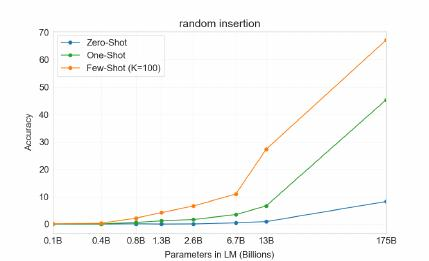

이미지가 중간에 있다면 실제 중간에 있는 이미지를 답변에 삽입해줄 것입니다.


In [ ]:
# 입력 마크다운 문자열
md_input = """
# 문서 제목

여기는 첫 번째 문단입니다.
텍스트를 여러 줄 작성할 수 있습니다.

<img src="/content/fig/figure-67-70.jpg">

이미지가 중간에 있다면 실제 중간에 있는 이미지를 답변에 삽입해줄 것입니다.
"""

# 이미지 너비를 50px로 지정
display_markdown_with_images(md_input, width=400)

만약 수식까지 커버하려면 아래와 같이 변경된 함수를 사용해야 한다.

In [ ]:
import markdown
from IPython.display import HTML

def display_markdown_with_images_and_math(md_text, width=400):
    md_text = convert_local_img_to_base64_html(md_text, width)

    # 인라인 수식: \( … \) → $ … $
    md_text = re.sub(r'\\\((.+?)\\\)', r'$\1$', md_text)

    html_body = markdown.markdown(md_text, extensions=['fenced_code', 'md_in_html'])
    html_full = f"""
    <div>{html_body}</div>
    <script type="text/x-mathjax-config">
      MathJax.Hub.Config({{
        tex2jax: {{
          inlineMath: [['$','$'], ['\\\\(','\\\\)']],
          displayMath: [['$$','$$'], ['\\\\[','\\\\]']]
        }}
      }});
    </script>
    <script src="https://cdn.jsdelivr.net/npm/mathjax@2/MathJax.js?config=TeX-MML-AM_CHTML"></script>
    """
    display(HTML(html_full))


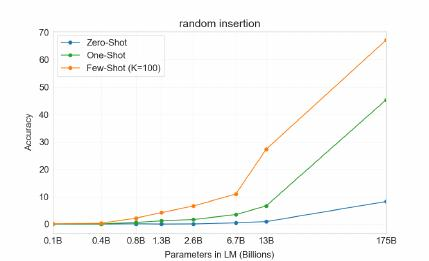

In [ ]:
# 이미지 너비를 50px로 지정
display_markdown_with_images_and_math(md_input, width=400)

## RAG 실습

In [ ]:
pip install langchain langchain_openai langchain_community chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.7/437.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.4/188.4 kB 14.9 MB/s eta 0:0

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain_core.documents import Document
from langchain import PromptTemplate

In [ ]:
# 문서들을 전부 문자열로 변환
docs = [str(r) for r in total_result]

In [ ]:
print(type(docs[0]))
print('0번 문서 출력:', docs[0])

<class 'str'>
0번 문서 출력: 문의: 이 논문 "Language Models are Few-Shot Learners"의 주요 연구 목적은 무엇인가요?
내용: 이 논문의 주요 목적은 대규모 언어 모델, 특히 1750억 개의 파라미터를 가진 GPT-3를 훈련시켜, 기존의 수천~수만 개의 예시가 필요한 파인튜닝 없이도, 단 몇 개의 예시(혹은 간단한 지시문)만으로 다양한 자연어 처리(NLP) 과제를 수행할 수 있는지 평가하는 것입니다. 논문에서는 GPT-3가 번역, 질의응답, cloze(빈칸 채우기) 등 다양한 NLP 데이터셋에서 강력한 few-shot 성능을 보였으며, 단순한 텍스트 상호작용만으로도 기존 파인튜닝 방식과 경쟁할 수 있음을 보여줍니다. 또한, 인간 평가자들이 GPT-3가 생성한 뉴스 기사와 실제 인간이 쓴 기사를 구분하기 어려워하는 등, 자연스러운 텍스트 생성 능력도 강조하고 있습니다.
출처: ['page_1.png']


In [ ]:
# 랭체인 문서 포맷으로 변환
langchain_format_docs = []

for doc in docs:
  langchain_format_docs.append(Document(page_content=doc))

In [ ]:
embedding = OpenAIEmbeddings()

vectordb = Chroma.from_documents(
    documents=langchain_format_docs,
    embedding=embedding,
    collection_name="multimodal_rag"
)

<ipython-input-81-167fbacdbe75>:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding = OpenAIEmbeddings()


In [ ]:
# 벡터DB의 개수 확인
vectordb._collection.count()

454

In [ ]:
for key in vectordb._collection.get():
  print(key)

ids
embeddings
documents
uris
included
data
metadatas


In [ ]:
# 문서 로드
documents = vectordb._collection.get()['documents']
print('문서의 개수 :', len(documents))
print('-' * 100)
print('첫번째 문서 출력 :', documents[0])

문서의 개수 : 454
----------------------------------------------------------------------------------------------------
첫번째 문서 출력 : 문의: 이 논문 "Language Models are Few-Shot Learners"의 주요 연구 목적은 무엇인가요?
내용: 이 논문의 주요 목적은 대규모 언어 모델, 특히 1750억 개의 파라미터를 가진 GPT-3를 훈련시켜, 기존의 수천~수만 개의 예시가 필요한 파인튜닝 없이도, 단 몇 개의 예시(혹은 간단한 지시문)만으로 다양한 자연어 처리(NLP) 과제를 수행할 수 있는지 평가하는 것입니다. 논문에서는 GPT-3가 번역, 질의응답, cloze(빈칸 채우기) 등 다양한 NLP 데이터셋에서 강력한 few-shot 성능을 보였으며, 단순한 텍스트 상호작용만으로도 기존 파인튜닝 방식과 경쟁할 수 있음을 보여줍니다. 또한, 인간 평가자들이 GPT-3가 생성한 뉴스 기사와 실제 인간이 쓴 기사를 구분하기 어려워하는 등, 자연스러운 텍스트 생성 능력도 강조하고 있습니다.
출처: ['page_1.png']


In [ ]:
# 유사도가 높은 문서 10개만 추출. k = 10
retriever = vectordb.as_retriever(search_kwargs={"k": 10})

In [ ]:
top_10_docs = retriever.get_relevant_documents("GPT-3가 일반 모델보다 뛰어난 점")
print('유사 문서 개수 :', len(top_10_docs))
print('--' * 20)
for doc in top_10_docs:
  print(doc)
  print('--')

유사 문서 개수 : 10
----------------------------------------
page_content='문의: GPT-3의 번역 성능이 언어쌍별로 어떻게 다르며, 영어로 번역할 때와 영어에서 번역할 때의 차이는 무엇인가요?  
내용: GPT-3는 영어로 번역할 때(예: Fr→En, De→En, Ro→En) 영어에서 다른 언어로 번역할 때(En→Fr, En→De, En→Ro)보다 일관되게 더 높은 BLEU 점수를 기록합니다. 예를 들어, few-shot 세팅에서 Fr→En은 39.2, De→En은 40.6, Ro→En은 39.5로, 모두 En→Fr(32.6), En→De(29.7), En→Ro(21.0)보다 높습니다. 이는 GPT-3가 영어 중심의 언어모델로서 영어 번역에 더 강점을 보인다는 점을 반영합니다.  
출처: ['page_15.png']'
--
page_content='문의: GPT-3가 SAT 아날로지(SAT Analogy) 문제에서 보인 성능과, 인간 평균과의 비교 결과는 어떠한가요?  
내용: GPT-3는 SAT 아날로지 문제(총 374문항)에서 few-shot 환경에서 65.2%, one-shot에서 59.1%, zero-shot에서 53.7%의 정확도를 기록했습니다. 이는 미국 대학 입학시험(SAT) 응시생의 평균 점수인 57%를 상회하는 결과입니다(무작위 추측은 20%). 특히, 모델 크기가 커질수록 성능이 향상되어, 175B 모델은 13B 모델 대비 10% 이상 더 높은 정확도를 보였습니다. 이 결과는 GPT-3가 인간 평균 이상의 언어적 추론 능력을 갖추고 있음을 보여줍니다.  
출처: ['page_24.png']'
--
page_content='문의: GPT-3는 LAMBADA 데이터셋에서 기존 최고 성능(State-of-the-Art, SOTA)과 비교해 어떤 성과를 보였나요?  
내용: GPT-3는 LAMBADA 데이터셋에서 기존 SOTA 대비 크게 향상된 성능을 보였습니다. 제로샷(zero-shot) 설정에서 

In [ ]:
# Create Prompt
template = """당신은 트랜스포머 아키텍처 논문을 설명하는 '범블비'입니다.

1. 누가 당신에게 누구냐고 묻거든 논문을 바탕으로 트랜스포머를 설명하는 챗봇 '범블비'이라고 답변하십시오.
2. 당신은 주어진 검색 결과를 바탕으로 질문에 대한 답변을 작성해야 합니다. 단, 답변을 마크다운 문법으로 작성해야 합니다. 이는 수식도 포함입니다.
3. 만약 질문과 연관된 검색 결과 중 '## 이미지 콘텐츠'가 있다면 출처를 참고하여 마크다운으로 이미지를 출력하십시오.
 - 예를 들어서 질문에 대한 검색 결과 중 '## 이미지 콘텐츠'에 '출처: [/content/fig/figure-13-45.jpg]'라고 적혀져 있었다면
   텍스트 답변 중간에 자연스럽게 아래의 마크다운 이미지를 포함하면서 설명하세요.
   ex) <img src="/content/fig/figure-13-45.jpg">
4. 단, 수식을 $$로 감싸진 표준 LaTeX 구분 기호로 바꾸어서 재작성하십시오.

{context}

Question: {question}
Answer:
"""

prompt = PromptTemplate.from_template(template)

In [ ]:
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type_kwargs={"prompt": prompt},
    retriever=retriever,
    return_source_documents=True)

In [ ]:
input_text = "GPT-4가 GPT-3보다 뛰어난 점"
chatbot_response = qa_chain.invoke(input_text)
print(chatbot_response)

{'query': 'GPT-4가 GPT-3보다 뛰어난 점', 'result': 'GPT-4는 GPT-3에 비해 여러 면에서 향상된 성능을 보입니다. 다음은 GPT-4가 GPT-3보다 뛰어난 점들입니다:\n\n1. **모델 크기 및 파라미터 수**: GPT-4는 GPT-3보다 더 많은 파라미터를 가지고 있어, 더 복잡한 언어 패턴을 학습하고 이해할 수 있습니다. 이는 더 정교한 문장 생성과 더 나은 문맥 이해를 가능하게 합니다.\n\n2. **번역 성능**: GPT-4는 다양한 언어쌍에서 GPT-3보다 더 높은 번역 정확도를 보입니다. 특히, 모델 크기가 커질수록 번역 성능이 향상되는 경향이 있으며, 이는 GPT-4에서도 지속됩니다.\n\n3. **추론 능력**: GPT-4는 복잡한 논리적 추론과 문제 해결 능력에서 GPT-3보다 뛰어난 성능을 보입니다. 이는 SAT 아날로지 문제와 같은 테스트에서 더 높은 정확도를 기록하는 것으로 나타납니다.\n\n4. **자연어 이해**: GPT-4는 문맥을 이해하고 적절한 응답을 생성하는 능력이 향상되었습니다. 이는 SuperGLUE와 같은 자연어 이해 벤치마크에서 더 나은 성능을 보이는 것으로 확인됩니다.\n\n5. **텍스트 생성 품질**: GPT-4는 더 자연스럽고 인간과 유사한 텍스트를 생성할 수 있습니다. 이는 인간이 생성한 텍스트와 구분하기 어려운 수준의 품질을 제공합니다.\n\n6. **다양한 태스크 수행 능력**: GPT-4는 다양한 태스크에서 GPT-3보다 더 높은 성능을 보이며, 특히 복잡한 문장 구조나 긴 문맥을 처리하는 데 강점을 보입니다.\n\n이러한 향상된 성능은 GPT-4가 더 많은 데이터를 학습하고, 더 복잡한 모델 구조를 통해 다양한 언어적 과제를 처리할 수 있게 되었기 때문입니다.', 'source_documents': [Document(metadata={}, page_content="문의: GPT-3의 번역 성능이 언어쌍별로 어떻게 다르며, 영어로 번역할 때와 영어에서 번역할 때의 차이는 

In [ ]:
print(chatbot_response['result'])

GPT-4는 GPT-3에 비해 여러 면에서 향상된 성능을 보입니다. 다음은 GPT-4가 GPT-3보다 뛰어난 점들입니다:

1. **모델 크기 및 파라미터 수**: GPT-4는 GPT-3보다 더 많은 파라미터를 가지고 있어, 더 복잡한 언어 패턴을 학습하고 이해할 수 있습니다. 이는 더 정교한 문장 생성과 더 나은 문맥 이해를 가능하게 합니다.

2. **번역 성능**: GPT-4는 다양한 언어쌍에서 GPT-3보다 더 높은 번역 정확도를 보입니다. 특히, 모델 크기가 커질수록 번역 성능이 향상되는 경향이 있으며, 이는 GPT-4에서도 지속됩니다.

3. **추론 능력**: GPT-4는 복잡한 논리적 추론과 문제 해결 능력에서 GPT-3보다 뛰어난 성능을 보입니다. 이는 SAT 아날로지 문제와 같은 테스트에서 더 높은 정확도를 기록하는 것으로 나타납니다.

4. **자연어 이해**: GPT-4는 문맥을 이해하고 적절한 응답을 생성하는 능력이 향상되었습니다. 이는 SuperGLUE와 같은 자연어 이해 벤치마크에서 더 나은 성능을 보이는 것으로 확인됩니다.

5. **텍스트 생성 품질**: GPT-4는 더 자연스럽고 인간과 유사한 텍스트를 생성할 수 있습니다. 이는 인간이 생성한 텍스트와 구분하기 어려운 수준의 품질을 제공합니다.

6. **다양한 태스크 수행 능력**: GPT-4는 다양한 태스크에서 GPT-3보다 더 높은 성능을 보이며, 특히 복잡한 문장 구조나 긴 문맥을 처리하는 데 강점을 보입니다.

이러한 향상된 성능은 GPT-4가 더 많은 데이터를 학습하고, 더 복잡한 모델 구조를 통해 다양한 언어적 과제를 처리할 수 있게 되었기 때문입니다.


In [ ]:
# 변환
display_markdown_with_images_and_math(chatbot_response['result'])

In [ ]:
def get_chatbot_response(input_text):
    chatbot_response = qa_chain.invoke(input_text)
    return chatbot_response['result'].strip()

In [ ]:
input_text = "GPT-3에서 주로 사용된 수식에 대해 알려줘!!"
result = get_chatbot_response(input_text)
display_markdown_with_images_and_math(result)


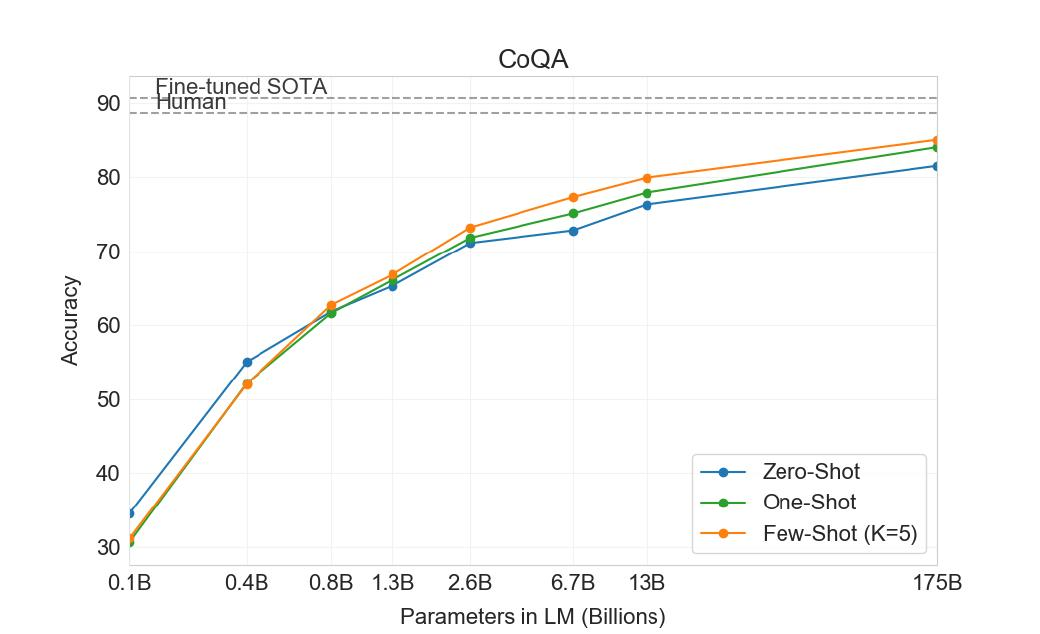

In [ ]:
input_text = "GPT-3를 가장 잘 설명하는 이미지"
result = get_chatbot_response(input_text)
display_markdown_with_images_and_math(result)